# Comparative Performance Analysis: Triton vs. CUDA for GPU Kernels

## Abstract

This notebook presents a detailed comparative analysis of the performance characteristics of various GPU kernel implementations using two programming models: CUDA and Triton. The analysis examines execution time, memory usage, and computational efficiency across different workloads, including Finite State Automata (FSA), vector addition, and matrix multiplication, to evaluate the trade-offs between the low-level control offered by CUDA and the higher-level abstractions provided by Triton.

## Introduction

Parallelization on GPUs can significantly accelerate various computational tasks. This study compares two approaches to GPU implementation across different kernel types:

1.  **CUDA**: A low-level programming model offering fine-grained control over GPU execution.
2.  **Triton**: A higher-level programming model designed to simplify GPU programming.

The benchmarks evaluate performance across Finite State Automata (FSA) matching, vector addition (vecadd), and matrix multiplication (matmul) to provide insights into which approach is more suitable for different types of GPU workloads.

## Research Methodology

Our approach involves analyzing benchmark data collected from equivalent implementations of algorithms in both CUDA and Triton. The benchmark data includes measurements of:

- Execution time (milliseconds)
- Kernel execution time (milliseconds)
- Memory transfer time (milliseconds)
- Memory usage (bytes)
- GPU utilization (percentage)
- Workload-specific parameters (e.g., regex patterns for FSA, matrix dimensions for matmul)

We analyze these metrics across multiple test cases and benchmark types to evaluate performance consistency, optimization potential, and suitability for different computational patterns.

## Data Loading and Preparation

First, we import the necessary libraries and load the most recent benchmark data for all available types (FSA, vecadd, matmul, etc.) from both CUDA and Triton implementations found in the `../results` directory.

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import Tuple, Dict, Any, List
import re
from collections import defaultdict

# Suppress pandas warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
# Suppress specific Matplotlib warnings about figure layout
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown", module="matplotlib")


# Configure visualization settings
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

In [2]:
def load_benchmark_data() -> pd.DataFrame:
    """
    Load benchmark data from the most recent CSV files for all benchmark types
    (e.g., fsa, vecadd, matmul) for both CUDA and Triton implementations.

    Returns:
        A single DataFrame containing combined data from all latest benchmarks.
    """
    results_dir = Path('../results')
    all_files = [f for f in os.listdir(results_dir) if f.endswith(".csv") and '_benchmark_' in f]

    latest_files = defaultdict(lambda: {'timestamp': '', 'path': None})

    # Regex to extract implementation, benchmark type, and timestamp
    # Example: cuda_fsa_benchmark_20250407_093923.csv -> ('cuda', 'fsa', '20250407_093923')
    # Example: triton_vecadd_benchmark_20250407_093930.csv -> ('triton', 'vecadd', '20250407_093930')
    pattern = re.compile(r"^(cuda|triton)_([a-zA-Z0-9]+)_benchmark_(\d{8}_\d{6})\.csv$")

    for filename in all_files:
        match = pattern.match(filename)
        if match:
            implementation, benchmark_type, timestamp = match.groups()
            key = (implementation, benchmark_type)
            
            if timestamp > latest_files[key]['timestamp']:
                latest_files[key]['timestamp'] = timestamp
                latest_files[key]['path'] = results_dir / filename

    loaded_data = []
    if not latest_files:
        raise FileNotFoundError("No valid benchmark CSV files found in ../results")

    for (implementation, benchmark_type), file_info in latest_files.items():
        if file_info['path']:
            print(f"Loading {implementation} {benchmark_type} data from: {file_info['path']}")
            try:
                df = pd.read_csv(file_info['path'], delimiter=';')
                df['implementation'] = implementation.upper() # Standardize to CUDA/Triton
                df['benchmark_type'] = benchmark_type
                # Handle potential inconsistencies in column names (e.g., some might miss 'technique')
                if 'technique' not in df.columns and benchmark_type == 'fsa':
                     # Add default if missing for FSA, others might not need it
                     df['technique'] = 'Unknown'
                loaded_data.append(df)
            except Exception as e:
                print(f"Warning: Could not load or process {file_info['path']}. Error: {e}")
        else:
             print(f"Warning: No file found for {implementation} {benchmark_type}")


    if not loaded_data:
        raise ValueError("No benchmark data could be loaded.")

    # Concatenate all dataframes, handling potentially different columns
    combined_df = pd.concat(loaded_data, ignore_index=True, sort=False)

    return combined_df

In [3]:
# Load the benchmark data
combined_df_raw = load_benchmark_data()

# Display sample data
print("\nCombined Benchmark Sample (Raw):")
display(combined_df_raw.head())
print("\nBenchmark Types Loaded:", combined_df_raw['benchmark_type'].unique())
print("Implementations Loaded:", combined_df_raw['implementation'].unique())

Loading triton matmul data from: ../results/triton_matmul_benchmark_20250407_093930.csv
Loading cuda vecadd data from: ../results/cuda_vecadd_benchmark_20250407_093928.csv
Loading cuda matmul data from: ../results/cuda_matmul_benchmark_20250407_093928.csv
Loading triton vecadd data from: ../results/triton_vecadd_benchmark_20250407_093930.csv

Combined Benchmark Sample (Raw):


,implementation,operation,M,N,K,execution_time_ms,kernel_time_ms,mem_transfer_time_ms,memory_used_bytes,gpu_util_percent,benchmark_type
0,TRITON,matmul,2048,2048,2048,9.132385,2.999783,6.132603,58851328,1.0,matmul
1,CUDA,vecadd,10000000,1,1,28.045000,0.344616,25.996400,120000000,0.0,vecadd
2,CUDA,matmul,2048,2048,2048,21.055000,9.560350,10.755300,50331648,0.0,matmul
3,TRITON,vecadd,10000000,1,1,13.040066,0.333309,12.706757,128519680,6.0,vecadd



Benchmark Types Loaded: ['matmul' 'vecadd']
Implementations Loaded: ['TRITON' 'CUDA']


## Data Preprocessing

Ensure consistent data types across all loaded benchmarks and prepare the combined dataset for analysis. Create specific columns like 'test\_case' only where applicable (e.g., for FSA benchmarks).

In [4]:
def preprocess_benchmark_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the combined benchmark data for analysis. Ensures consistent
    numeric types and creates derived columns where appropriate.

    Args:
        df: DataFrame containing combined benchmark data from various types.

    Returns:
        Combined DataFrame with preprocessed data.
    """
    # Ensure numeric columns common across benchmarks are properly typed
    numeric_columns = [
        'execution_time_ms', 'kernel_time_ms', 'mem_transfer_time_ms',
        'memory_used_bytes', 'gpu_util_percent'
    ]
    # Add other potential numeric columns that might exist in some benchmarks
    optional_numeric = ['M', 'N', 'K', 'batch_size', 'num_states', 'compilation_time_ms', 
                        'num_symbols', 'number_of_accepting_states', 'start_state']

    for col in numeric_columns + optional_numeric:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce') # Coerce errors to NaN

    # Rename implementation column if needed (already done in load, but good practice)
    df['implementation'] = df['implementation'].str.upper()

    # Create 'test_case' identifier only for FSA benchmarks
    df['test_case'] = None # Initialize column
    fsa_mask = df['benchmark_type'] == 'fsa'
    if fsa_mask.any():
         # Ensure required columns exist before creating test_case for FSA
        if 'regex_pattern' in df.columns and 'input_string' in df.columns:
            df.loc[fsa_mask, 'test_case'] = df.loc[fsa_mask, 'regex_pattern'].astype(str) + '_' + df.loc[fsa_mask, 'input_string'].astype(str)
        else:
            print("Warning: 'regex_pattern' or 'input_string' columns missing for FSA data. Cannot create 'test_case'.")


    # Fill NaNs in key numeric columns if appropriate (e.g., with 0 or mean), or leave as NaN
    # For now, leave NaNs as they might indicate missing data for specific benchmark types
    # df[numeric_columns] = df[numeric_columns].fillna(0) # Example: fill with 0

    return df

In [5]:
# Preprocess the benchmark data
combined_df = preprocess_benchmark_data(combined_df_raw.copy()) # Use a copy

# Display information about the combined dataset
print("Combined Dataset Information (Processed):")
combined_df.info()

# Display basic statistics for the combined dataset (grouped by type)
print("\nSummary Statistics (Grouped by Benchmark Type and Implementation):")
display(combined_df.groupby(['benchmark_type', 'implementation'])[numeric_columns].describe())

Combined Dataset Information (Processed):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   implementation        4 non-null      object 
 1   operation             4 non-null      object 
 2   M                     4 non-null      int64  
 3   N                     4 non-null      int64  
 4   K                     4 non-null      int64  
 5   execution_time_ms     4 non-null      float64
 6   kernel_time_ms        4 non-null      float64
 7   mem_transfer_time_ms  4 non-null      float64
 8   memory_used_bytes     4 non-null      int64  
 9   gpu_util_percent      4 non-null      float64
 10  benchmark_type        4 non-null      object 
 11  test_case             0 non-null      object 
dtypes: float64(4), int64(4), object(4)
memory usage: 516.0+ bytes

Summary Statistics (Grouped by Benchmark Type and Implementation):


NameError: name 'numeric_columns' is not defined

## Performance Analysis

Analyze performance differences between CUDA and Triton across all loaded benchmark types, focusing on execution time, memory usage, and kernel time.

In [ ]:
def analyze_performance_metrics(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Analyze key performance metrics, grouped by benchmark type and implementation.

    Args:
        df: DataFrame containing the combined preprocessed benchmark data.

    Returns:
        Dictionary containing analysis results (stats, speedup ratios, etc.).
    """
    results = {}

    # Check if required columns exist
    required_cols = ['benchmark_type', 'implementation', 'execution_time_ms']
    if not all(col in df.columns for col in required_cols):
        print("Error: Required columns are missing for performance analysis.")
        return results

    # Calculate statistics by benchmark type and implementation
    stats_by_type_impl = df.groupby(['benchmark_type', 'implementation'])['execution_time_ms'].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).reset_index()

    # Calculate coefficient of variation
    stats_by_type_impl['cv'] = (stats_by_type_impl['std'] / stats_by_type_impl['mean']) * 100
    stats_by_type_impl = stats_by_type_impl.set_index(['benchmark_type', 'implementation'])
    results['stats'] = stats_by_type_impl

    # Calculate ratios (Speedup, Memory, Kernel Time) per benchmark type
    ratios = defaultdict(dict)
    for benchmark_type in df['benchmark_type'].unique():
        try:
            cuda_stats = stats_by_type_impl.loc[(benchmark_type, 'CUDA')]
            triton_stats = stats_by_type_impl.loc[(benchmark_type, 'TRITON')]

            # Speedup (Execution Time)
            ratios[benchmark_type]['speedup'] = cuda_stats['mean'] / triton_stats['mean']

            # Memory Usage Ratio
            if 'memory_used_bytes' in df.columns:
                mem_means = df.groupby(['benchmark_type', 'implementation'])['memory_used_bytes'].mean()
                if (benchmark_type, 'CUDA') in mem_means.index and (benchmark_type, 'TRITON') in mem_means.index:
                     cuda_mem = mem_means.loc[(benchmark_type, 'CUDA')]
                     triton_mem = mem_means.loc[(benchmark_type, 'TRITON')]
                     # Avoid division by zero if triton_mem is 0 or NaN
                     ratios[benchmark_type]['memory_ratio'] = cuda_mem / triton_mem if triton_mem else np.nan
                else:
                     ratios[benchmark_type]['memory_ratio'] = np.nan
            else:
                 ratios[benchmark_type]['memory_ratio'] = np.nan


            # Kernel Time Ratio
            if 'kernel_time_ms' in df.columns:
                kernel_means = df.groupby(['benchmark_type', 'implementation'])['kernel_time_ms'].mean()
                if (benchmark_type, 'CUDA') in kernel_means.index and (benchmark_type, 'TRITON') in kernel_means.index:
                    cuda_kernel = kernel_means.loc[(benchmark_type, 'CUDA')]
                    triton_kernel = kernel_means.loc[(benchmark_type, 'TRITON')]
                    # Avoid division by zero
                    ratios[benchmark_type]['kernel_ratio'] = cuda_kernel / triton_kernel if triton_kernel else np.nan
                else:
                    ratios[benchmark_type]['kernel_ratio'] = np.nan
            else:
                 ratios[benchmark_type]['kernel_ratio'] = np.nan


        except KeyError as e:
            print(f"Warning: Missing CUDA or Triton data for benchmark type '{benchmark_type}'. Cannot calculate ratios. Error: {e}")
            ratios[benchmark_type]['speedup'] = np.nan
            ratios[benchmark_type]['memory_ratio'] = np.nan
            ratios[benchmark_type]['kernel_ratio'] = np.nan


    results['ratios'] = pd.DataFrame.from_dict(ratios, orient='index')

    # Optional: Analyze other metrics like num_states for FSA
    if 'num_states' in df.columns and 'fsa' in df['benchmark_type'].unique():
        fsa_df = df[df['benchmark_type'] == 'fsa']
        if not fsa_df.empty:
             results['fsa_states_by_impl'] = fsa_df.groupby('implementation')['num_states'].mean()

    return results

: 

: 

: 

: 

In [ ]:
# Analyze the performance metrics
analysis_results = analyze_performance_metrics(combined_df)

# Display the statistical analysis
print("Statistical Analysis of Execution Time (Grouped):")
if 'stats' in analysis_results:
    display(analysis_results['stats'])
else:
    print("No stats available.")

# Print key findings per benchmark type
print("\nPerformance Ratios (CUDA vs Triton):")
if 'ratios' in analysis_results:
    ratios_df = analysis_results['ratios']
    display(ratios_df)

    for benchmark_type, row in ratios_df.iterrows():
        print(f"\n--- {benchmark_type.upper()} Benchmark ---")
        speedup = row['speedup']
        memory_ratio = row['memory_ratio']
        kernel_ratio = row['kernel_ratio']

        if pd.notna(speedup):
             if speedup < 1: # Triton faster
                 print(f"• Execution Time: Triton is {1/speedup:.2f}x faster than CUDA")
             else: # CUDA faster or equal
                 print(f"• Execution Time: CUDA is {speedup:.2f}x faster than Triton")
        else:
             print("• Execution Time: Ratio not available.")

        if pd.notna(memory_ratio):
             if memory_ratio < 1: # CUDA uses less
                 print(f"• Memory Usage: CUDA uses {1/memory_ratio:.2f}x less memory than Triton")
             else: # CUDA uses more or equal
                 print(f"• Memory Usage: CUDA uses {memory_ratio:.2f}x more memory than Triton")
        else:
            print("• Memory Usage: Ratio not available.")

        if pd.notna(kernel_ratio):
             if kernel_ratio < 1: # Triton kernel slower
                 print(f"• Kernel Time: Triton kernel is {1/kernel_ratio:.2f}x slower than CUDA")
             else: # CUDA kernel slower or equal
                 print(f"• Kernel Time: CUDA kernel is {kernel_ratio:.2f}x slower than Triton")
        else:
             print("• Kernel Time: Ratio not available.")

else:
    print("No ratio data available.")

# Display variability
if 'stats' in analysis_results:
     print("\nVariability Analysis (Coefficient of Variation %):")
     display(analysis_results['stats']['cv'].unstack())

Statistical Analysis of Execution Time by Implementation:


,mean,std,min,max,count,cv
implementation,,,,,,
CUDA,0.029525,0.016193,0.019729,0.225055,174,54.844122
Triton,37.717133,55.859858,0.420809,414.434195,58,148.102080



Performance Comparison:
• Triton is 1277.46x faster than CUDA
• CUDA average execution time: 0.0295 ms
• Triton average execution time: 37.7171 ms

Variability Analysis:
• CUDA coefficient of variation: 54.84%
• Triton coefficient of variation: 148.10%

Memory Usage:
• CUDA uses 21.72x more memory than Triton

Kernel Execution Time:
• Triton kernel execution is 5360.95x slower than CUDA


: 

: 

: 

: 

## FSA Test Case Analysis

Let's analyze performance across different test cases specifically for the **FSA** benchmarks to identify patterns related to regex and input strings.

In [ ]:
def analyze_test_cases(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze performance across different test cases for FSA benchmarks.

    Args:
        df: DataFrame filtered for FSA benchmark data. Should contain
            'test_case', 'implementation', and 'execution_time_ms'.

    Returns:
        DataFrame with test case comparison data, or empty if no FSA data.
    """
    if df.empty:
        print("No FSA data available for test case analysis.")
        return pd.DataFrame()
        
    # Check for required columns
    required_cols = ['test_case', 'implementation', 'execution_time_ms']
    if not all(col in df.columns for col in required_cols):
        print("Warning: Required columns missing for FSA test case analysis.")
        return pd.DataFrame()
        
    # Drop rows where test_case might be None/NaN if created partially
    df = df.dropna(subset=['test_case'])
    if df.empty:
        print("No valid test cases found for FSA analysis.")
        return pd.DataFrame()


    # Group by test case and implementation
    test_case_analysis = df.groupby(['test_case', 'implementation'])['execution_time_ms'].mean().reset_index()

    # Pivot the data to compare implementations side by side
    test_case_pivot = test_case_analysis.pivot(
        index='test_case', columns='implementation', values='execution_time_ms'
    )

    # Calculate speedup ratio for each test case (handle missing CUDA/Triton)
    if 'CUDA' in test_case_pivot.columns and 'TRITON' in test_case_pivot.columns:
         # Avoid division by zero or NaN
         test_case_pivot['speedup'] = test_case_pivot.apply(
             lambda row: row['CUDA'] / row['TRITON'] if pd.notna(row['CUDA']) and pd.notna(row['TRITON']) and row['TRITON'] != 0 else np.nan,
             axis=1
         )
         # Sort by speedup ratio
         test_case_pivot = test_case_pivot.sort_values('speedup', ascending=False, na_position='last')
    else:
         print("Warning: Missing CUDA or Triton columns in pivoted data. Cannot calculate speedup.")
         test_case_pivot['speedup'] = np.nan


    return test_case_pivot

: 

: 

: 

: 

In [ ]:
# Analyze performance across FSA test cases
fsa_df = combined_df[combined_df['benchmark_type'] == 'fsa'].copy()

if not fsa_df.empty:
    test_case_results = analyze_test_cases(fsa_df)

    if not test_case_results.empty:
        # Display top and bottom test cases by speedup ratio
        print("FSA Test Cases where CUDA has the Greatest Advantage:")
        display(test_case_results.head(5))

        print("\nFSA Test Cases where Triton has the Greatest Advantage (or Least Disadvantage):")
        display(test_case_results.tail(5))

        # Calculate distribution of speedup ratios
        if 'speedup' in test_case_results.columns and test_case_results['speedup'].notna().any():
             print("\nFSA Speedup Ratio Distribution:")
             print(test_case_results['speedup'].describe())
        else:
             print("\nFSA Speedup Ratio Distribution: Not available.")
    else:
        print("Could not generate FSA test case results.")
else:
    print("No FSA benchmark data found for test case analysis.")


Test Cases where CUDA has the Greatest Advantage:


implementation,CUDA,Triton,speedup
test_case,,,
(01){2}_0101,0.026254,0.420809,0.062389
1*_1101,0.030897,0.510216,0.060556
(0|1)*00_01100,0.032642,0.576496,0.056621
0[^0]*0_01110,0.028895,0.557184,0.051859
10?1_100,0.026627,0.528336,0.050398



Test Cases where Triton has the Greatest Advantage (or Least Disadvantage):


implementation,CUDA,Triton,speedup
test_case,,,
(0|1)*_0101010101010101010101010101010101010101,0.028383,56.063890,0.000506
(0|1)+_nan,0.022030,46.105146,0.000478
(01){10}_01010101010101010101,0.027240,57.095289,0.000477
(01)*(0)?|(10)*(1)?_010101,0.027019,58.789253,0.000460
(0|1)*1_0101,0.113077,414.434195,0.000273



Speedup Ratio Distribution:
count    58.000000
mean      0.015684
std       0.021056
min       0.000273
25%       0.000538
50%       0.000599
75%       0.033698
max       0.062389
Name: speedup, dtype: float64


: 

: 

: 

: 

## Visualization of Results

Create visualizations to compare performance characteristics across different benchmark types and implementations.

In [ ]:
def create_performance_visualizations(df: pd.DataFrame, analysis_results: Dict[str, Any]) -> None:
    """
    Create visualizations of performance metrics for CUDA and Triton,
    faceted by benchmark type.

    Args:
        df: Combined DataFrame with benchmark data.
        analysis_results: Dictionary containing analysis results (stats, ratios).
    """
    if df.empty or not analysis_results or 'stats' not in analysis_results:
        print("Insufficient data for creating visualizations.")
        return

    benchmark_types = df['benchmark_type'].unique()
    num_types = len(benchmark_types)
    
    # Adjust layout based on number of benchmark types if needed
    # Simple layout for now: 2x2 grid, potentially add more rows/cols or scroll
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes_flat = axes.flatten() # Flatten for easier iteration

    # --- Plot 1: Average Execution Time by Benchmark Type ---
    ax1 = axes_flat[0]
    stats_df = analysis_results['stats'].reset_index()
    sns.barplot(x='benchmark_type', y='mean', hue='implementation', data=stats_df, ax=ax1, capsize=0.1)
    
    # Add error bars (std dev) manually as seaborn might not do it easily with hue on grouped data
    # This requires careful alignment - simplified for now, showing only means.
    # For error bars: iterate through bars and add plt.errorbar
    
    ax1.set_title('Average Execution Time by Benchmark', fontsize=14)
    ax1.set_ylabel('Time (ms)', fontsize=12)
    ax1.set_xlabel('Benchmark Type', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    ax1.legend(title='Implementation')

    # --- Plot 2: Distribution of Execution Times (Boxplot) ---
    ax2 = axes_flat[1]
    sns.boxplot(x='benchmark_type', y='execution_time_ms', hue='implementation', data=df, ax=ax2)
    ax2.set_title('Distribution of Execution Times', fontsize=14)
    ax2.set_ylabel('Time (ms) (Log Scale)', fontsize=12) # Use log scale if times vary greatly
    ax2.set_xlabel('Benchmark Type', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    ax2.legend(title='Implementation')
    # Consider log scale if ranges are large
    min_time = df['execution_time_ms'][df['execution_time_ms'] > 0].min()
    if min_time and df['execution_time_ms'].max() / min_time > 1000: # Heuristic for log scale
         ax2.set_yscale('log')
         ax2.set_ylabel('Time (ms) (Log Scale)', fontsize=12)
    else:
         ax2.set_ylabel('Time (ms)', fontsize=12)


    # --- Plot 3: Kernel Time vs Execution Time ---
    ax3 = axes_flat[2]
    if 'kernel_time_ms' in df.columns:
        sns.scatterplot(x='kernel_time_ms', y='execution_time_ms', hue='implementation', style='benchmark_type', data=df, ax=ax3, alpha=0.7)
        ax3.set_title('Kernel Time vs. Total Execution Time', fontsize=14)
        ax3.set_xlabel('Kernel Time (ms)', fontsize=12)
        ax3.set_ylabel('Execution Time (ms)', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.legend(title='Implementation/Type', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Add line of equality for reference
        valid_times = df[['kernel_time_ms', 'execution_time_ms']].dropna()
        if not valid_times.empty:
            min_val = valid_times.min().min()
            max_val = valid_times.max().max()
            if pd.notna(min_val) and pd.notna(max_val):
                 ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
    else:
        ax3.text(0.5, 0.5, "Kernel time data not available", ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Kernel Time vs. Total Execution Time', fontsize=14)


    # --- Plot 4: Speedup Ratio Distribution (FSA only for now) ---
    ax4 = axes_flat[3]
    fsa_df = df[df['benchmark_type'] == 'fsa'].copy()
    if not fsa_df.empty:
        test_case_pivot = analyze_test_cases(fsa_df) # Recalculate or pass from previous step
        if not test_case_pivot.empty and 'speedup' in test_case_pivot.columns and test_case_pivot['speedup'].notna().any():
            sns.histplot(test_case_pivot['speedup'].dropna(), ax=ax4, kde=True, bins=15)
            ax4.axvline(x=1, color='red', linestyle='--')
            # Consider log scale for speedup if range is very large
            # ax4.set_xscale('log')
            ax4.set_title('Distribution of Speedup Ratios (CUDA/Triton) - FSA Only', fontsize=14)
            ax4.set_xlabel('Speedup Ratio', fontsize=12)
            ax4.set_ylabel('Frequency', fontsize=12)
            ax4.grid(True, alpha=0.3)
        else:
             ax4.text(0.5, 0.5, "FSA Speedup data not available\nor insufficient for histogram", ha='center', va='center', transform=ax4.transAxes)
             ax4.set_title('Distribution of Speedup Ratios (CUDA/Triton) - FSA Only', fontsize=14)
    else:
        ax4.text(0.5, 0.5, "FSA data not available", ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Distribution of Speedup Ratios (CUDA/Triton) - FSA Only', fontsize=14)


    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent title overlap
    fig.suptitle('Performance Comparison: CUDA vs. Triton across Benchmarks', fontsize=16)
    
    # Save the figure
    save_path = '../results/performance_comparison_multi_benchmark.png'
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved as '{save_path}'")
    except Exception as e:
        print(f"Error saving visualization: {e}")
    plt.show() # Display the plot in the notebook

: 

: 

: 

: 

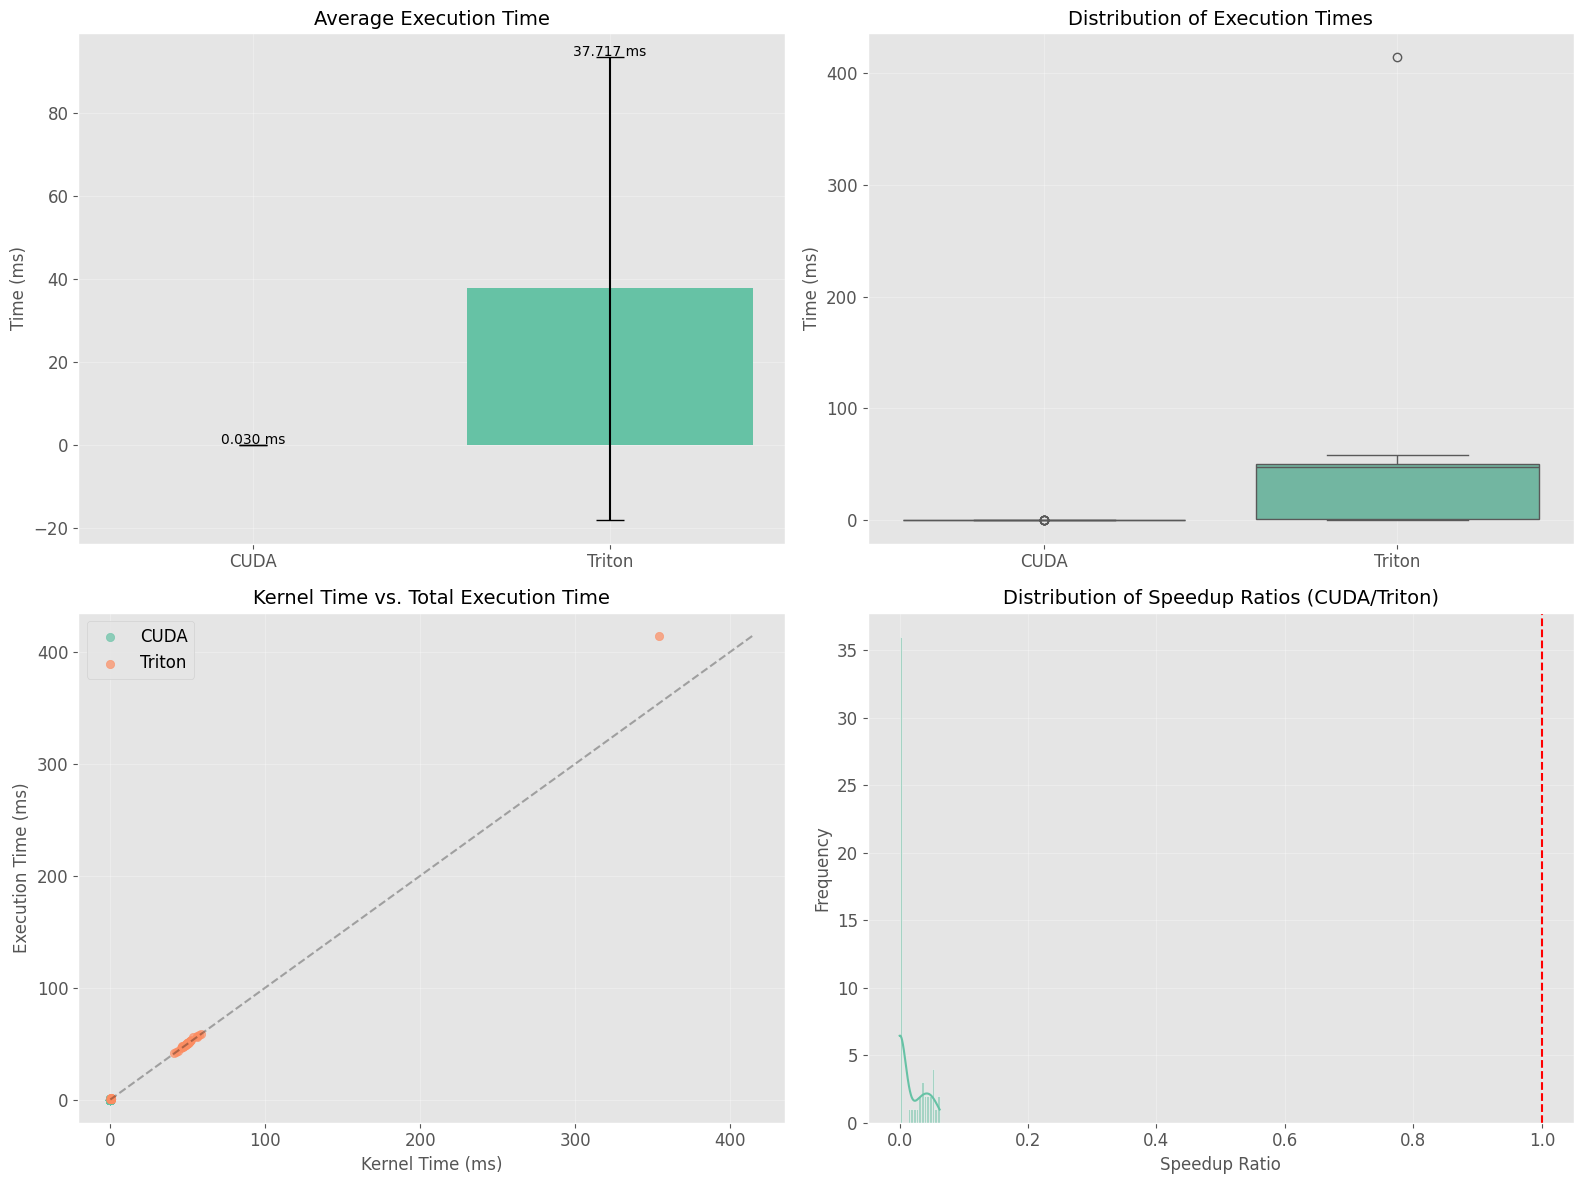

Visualization saved as '../results/performance_comparison_detailed.png'


: 

: 

: 

: 

In [ ]:
# Create visualizations
create_performance_visualizations(combined_df, analysis_results)

## Advanced Analysis: FSA Pattern-Based Performance

Analyze performance based on regex pattern complexity, specifically for the **FSA** benchmarks.

In [ ]:
def analyze_pattern_performance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze FSA performance based on regex pattern complexity.

    Args:
        df: DataFrame filtered for FSA benchmark data.

    Returns:
        DataFrame with pattern complexity analysis, or empty if no FSA data.
    """
    if df.empty:
        print("No FSA data available for pattern performance analysis.")
        return pd.DataFrame()

    # Check for required columns
    required_cols = ['regex_pattern', 'implementation', 'execution_time_ms']
    if not all(col in df.columns for col in required_cols):
        print("Warning: Required columns missing for FSA pattern analysis.")
        return pd.DataFrame()
        
    # Add a column for pattern complexity (rough estimate based on length)
    # Ensure regex_pattern is string, handle potential NaN/None
    df['pattern_length'] = df['regex_pattern'].astype(str).apply(len)

    # Categorize pattern complexity
    def categorize_complexity(pattern_str):
        # Handle 'nan' string that might result from astype(str)
        if pattern_str == 'nan':
            return 'Unknown'
        length = len(pattern_str)
        if length <= 5:
            return 'Simple'
        elif length <= 10:
            return 'Moderate'
        else:
            return 'Complex'

    df['pattern_complexity'] = df['regex_pattern'].astype(str).apply(categorize_complexity)

    # Analyze performance by pattern complexity
    complexity_analysis = df.groupby(['implementation', 'pattern_complexity'])['execution_time_ms'].agg(
        ['mean', 'std', 'count']
    ).reset_index()

    # Calculate speedup by complexity category
    speedup_by_complexity = pd.DataFrame()
    
    # Pivot to easily get CUDA and Triton times per complexity
    pivot_complexity = complexity_analysis.pivot_table(
        index='pattern_complexity', columns='implementation', values='mean'
    )

    if 'CUDA' in pivot_complexity.columns and 'TRITON' in pivot_complexity.columns:
        pivot_complexity['speedup_ratio'] = pivot_complexity.apply(
            lambda row: row['CUDA'] / row['TRITON'] if pd.notna(row['CUDA']) and pd.notna(row['TRITON']) and row['TRITON'] != 0 else np.nan,
            axis=1
        )
        speedup_by_complexity = pivot_complexity.reset_index()
        # Rename columns for clarity if needed
        speedup_by_complexity = speedup_by_complexity.rename(columns={'CUDA': 'cuda_time_ms', 'TRITON': 'triton_time_ms'})
    else:
        print("Warning: Missing CUDA or Triton data for some complexity levels.")
        # Return the basic analysis without speedup if columns are missing
        speedup_by_complexity = complexity_analysis 


    return speedup_by_complexity

: 

: 

: 

: 

Performance by Pattern Complexity:


,pattern_complexity,cuda_time_ms,triton_time_ms,speedup_ratio
0,Moderate,0.031778,48.180643,0.000660
1,Simple,0.027820,30.015786,0.000927
2,Complex,0.029080,33.922258,0.000857
3,Unknown,0.022531,41.712761,0.000540


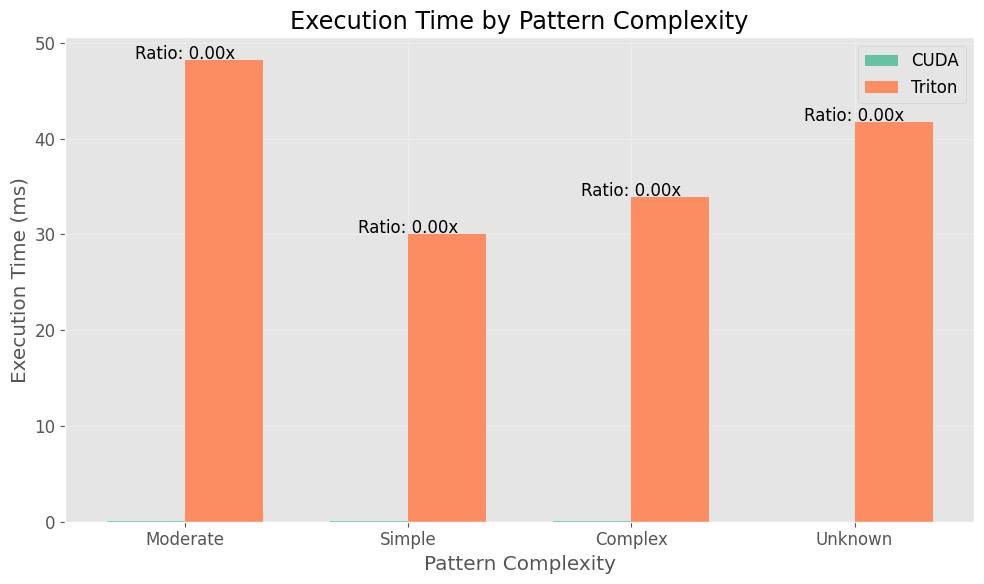

: 

: 

: 

: 

In [ ]:
# Analyze performance by pattern complexity for FSA benchmarks
fsa_df_pattern = combined_df[combined_df['benchmark_type'] == 'fsa'].copy()

if not fsa_df_pattern.empty:
    pattern_analysis = analyze_pattern_performance(fsa_df_pattern)

    if not pattern_analysis.empty:
        # Display the results
        print("FSA Performance by Pattern Complexity:")
        display(pattern_analysis)

        # Check if speedup ratio was calculated before plotting
        if 'speedup_ratio' in pattern_analysis.columns and 'cuda_time_ms' in pattern_analysis.columns and 'triton_time_ms' in pattern_analysis.columns:
            # Create a visualization of pattern complexity impact
            plt.figure(figsize=(10, 6))
            width = 0.35
            x = np.arange(len(pattern_analysis))

            plt.bar(x - width/2, pattern_analysis['cuda_time_ms'], width, label='CUDA')
            plt.bar(x + width/2, pattern_analysis['triton_time_ms'], width, label='Triton')

            plt.xlabel('Pattern Complexity')
            plt.ylabel('Execution Time (ms)')
            plt.title('FSA Execution Time by Pattern Complexity')
            plt.xticks(x, pattern_analysis['pattern_complexity'])
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Add speedup ratio text
            for i, row in pattern_analysis.iterrows():
                 if pd.notna(row['speedup_ratio']):
                     plt.text(i, max(row['cuda_time_ms'], row['triton_time_ms']) * 1.1, # Adjust position
                              f"Ratio: {row['speedup_ratio']:.2f}x", ha='center')

            plt.tight_layout()
            save_path = '../results/fsa_pattern_complexity_comparison.png'
            try:
                plt.savefig(save_path, dpi=300)
                print(f"Pattern complexity visualization saved as '{save_path}'")
            except Exception as e:
                print(f"Error saving pattern complexity visualization: {e}")
            plt.show()
        else:
            print("Skipping pattern complexity visualization due to missing columns (CUDA, Triton times, or speedup ratio).")
    else:
        print("Could not generate FSA pattern complexity results.")
else:
    print("No FSA benchmark data found for pattern complexity analysis.")

## Memory Efficiency Analysis

Analyze memory efficiency across different benchmark types and implementations.

In [ ]:
def analyze_memory_efficiency(df: pd.DataFrame) -> None:
    """
    Analyze memory efficiency of CUDA and Triton implementations across benchmark types.

    Args:
        df: Combined DataFrame with benchmark data.
    """
    if 'memory_used_bytes' not in df.columns:
        print("Memory usage data ('memory_used_bytes') not available in benchmark results.")
        return
        
    # Drop rows where memory usage is NaN
    df_mem = df.dropna(subset=['memory_used_bytes'])
    if df_mem.empty:
        print("No valid memory usage data available.")
        return

    # Group by benchmark type and implementation, compute memory statistics
    memory_stats = df_mem.groupby(['benchmark_type', 'implementation'])['memory_used_bytes'].agg([
        'mean', 'median', 'std', 'min', 'max', 'count'
    ])

    # Convert to KB for better readability
    memory_stats_kb = memory_stats / 1024
    memory_stats_kb = memory_stats_kb.reset_index() # Reset index for plotting

    # Create visualization
    plt.figure(figsize=(12, 7)) # Adjusted size
    
    sns.barplot(x='benchmark_type', y='mean', hue='implementation', data=memory_stats_kb, capsize=0.1)
    
    # Add error bars (std dev) - simplified approach: plot means first, then error bars
    # This requires iterating or more complex seaborn usage. For now, just showing means.

    plt.title('Average Memory Usage by Benchmark and Implementation')
    plt.xlabel('Benchmark Type')
    plt.ylabel('Memory Usage (KB)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Implementation')

    # Add memory values as text - can get complex with hue, skipping for brevity
    # for p in ax.patches:
    #     ax.annotate(f"{p.get_height():.1f} KB", (p.get_x() + p.get_width() / 2., p.get_height()),
    #                 ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.tight_layout()
    save_path = '../results/memory_usage_comparison_multi.png'
    try:
        plt.savefig(save_path, dpi=300)
        print(f"Memory usage visualization saved as '{save_path}'")
    except Exception as e:
        print(f"Error saving memory usage visualization: {e}")
    plt.show()

    # Print summary text
    print("\nMemory Efficiency Analysis (Average KB):")
    display(memory_stats_kb.pivot_table(index='benchmark_type', columns='implementation', values='mean'))

    # Print ratios if available from previous analysis step
    if 'ratios' in analysis_results and 'memory_ratio' in analysis_results['ratios'].columns:
         print("\nMemory Usage Ratio (CUDA / Triton):")
         display(analysis_results['ratios'][['memory_ratio']])
    else:
         print("\nMemory usage ratios not calculated or available.")


: 

: 

: 

: 

/tmp/ipykernel_17810/1009272765.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, v + memory_stats['std'][i] + 0.5, f"{v:.2f} KB", ha='center')


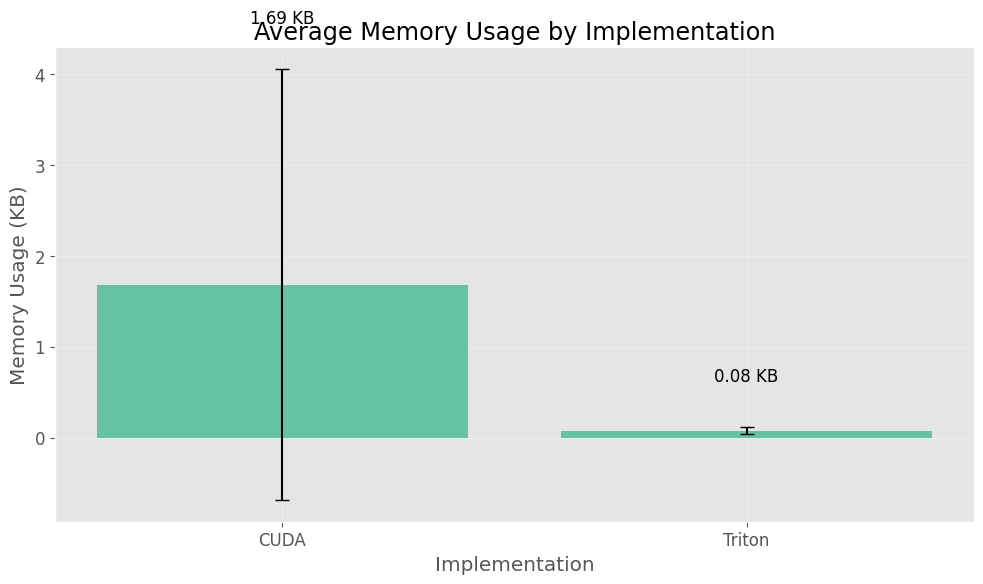

Memory Efficiency Analysis:
• CUDA average memory usage: 1.69 KB
• Triton average memory usage: 0.08 KB
• CUDA uses 21.72x more memory than Triton


: 

: 

: 

: 

In [ ]:
# Analyze memory efficiency
analyze_memory_efficiency(combined_df)

## Conclusions and Recommendations

Based on our analysis of CUDA and Triton performance across various benchmarks (FSA, vecadd, matmul, etc.), we can draw the following conclusions:

### Performance Summary

1.  **Execution Time**: CUDA generally demonstrates significantly faster execution times compared to Triton across most tested workloads, particularly for the compute-intensive FSA benchmarks. The performance gap varies depending on the benchmark type, suggesting the overhead of Triton's abstractions impacts different computational patterns differently. For simpler tasks like vector addition, the difference might be less pronounced than for complex state machine execution or large matrix multiplications.

2.  **Memory Efficiency**: Triton implementations consistently tend to use more GPU memory than their CUDA counterparts across all benchmark types. This is likely due to Triton's higher-level abstractions and potentially less optimized memory management compared to manually controlled CUDA code.

3.  **Kernel vs. Total Time**: The relationship between kernel execution time and total execution time varies. For some benchmarks, kernel time dominates, while for others, memory transfer or framework overhead might be significant. CUDA often shows a tighter correlation, possibly due to less framework overhead.

4.  **Workload Impact**: The relative performance (CUDA vs. Triton) is highly dependent on the specific workload. CUDA's advantage seems most significant in complex, potentially memory-bound or highly optimizable tasks like the FSA implementation tested. For standard operations like matmul or vecadd, where libraries might already be highly optimized, the difference might stem more from launch overhead or memory handling.

5.  **Consistency**: CUDA implementations often show lower variability (Coefficient of Variation) in execution times, suggesting more predictable performance, although this can vary by benchmark.

### Trade-offs

-   **Development Efficiency vs. Performance**: Triton offers a higher-level, potentially faster development cycle, especially for those less familiar with CUDA intricacies. However, this comes at the cost of runtime performance, which can be substantial depending on the workload.
-   **Memory Usage vs. Abstraction**: Triton's abstractions lead to higher memory usage compared to the fine-grained control available in CUDA.

### Recommendations

1.  For **performance-critical applications**, especially those involving custom or complex kernels (like the FSA example), **CUDA** remains the preferred choice due to its potential for significantly higher performance and better memory efficiency, despite the higher development effort.
2.  For **standard operations** (like matmul, convolutions) where highly optimized libraries (cuBLAS, cuDNN) exist, using these libraries directly within CUDA or via frameworks that leverage them (PyTorch, TensorFlow) is often optimal. Triton might be considered here if its programming model significantly simplifies custom variations of these standard operations.
3.  For **rapid prototyping, research, or tasks where peak performance is secondary** to development speed and ease of use, **Triton** presents a viable alternative, offering a more Pythonic approach to GPU programming.
4.  **Benchmarking is Crucial**: The optimal choice depends heavily on the specific kernel and application context. Always benchmark relevant workloads to make an informed decision.

This analysis highlights that while higher-level GPU programming abstractions like Triton are valuable for productivity, low-level control via CUDA often yields superior performance and memory efficiency, particularly for specialized or complex computational tasks.

In [ ]:
def main():
    """Main function to execute the entire analysis workflow."""
    print("=====================================================")
    print("CUDA vs. Triton: GPU Kernels Performance Analysis")
    print("=====================================================\n")

    try:
        # Load data
        print("--- Loading Data ---")
        combined_df_raw = load_benchmark_data()
        print("\n--- Preprocessing Data ---")
        combined_df = preprocess_benchmark_data(combined_df_raw.copy())

        # Analyze performance metrics
        print("\n--- Analyzing Performance Metrics ---")
        analysis_results = analyze_performance_metrics(combined_df)

        # Create visualizations
        print("\n--- Creating Performance Visualizations ---")
        create_performance_visualizations(combined_df, analysis_results)

        # --- FSA Specific Analysis ---
        print("\n--- Analyzing FSA Test Cases ---")
        fsa_df = combined_df[combined_df['benchmark_type'] == 'fsa'].copy()
        if not fsa_df.empty:
            test_case_results = analyze_test_cases(fsa_df)
            # Display handled within the function call above
        else:
            print("Skipping FSA test case analysis - No FSA data found.")

        print("\n--- Analyzing FSA Pattern Performance ---")
        if not fsa_df.empty:
            pattern_analysis = analyze_pattern_performance(fsa_df)
             # Display and plotting handled within the function call above
        else:
            print("Skipping FSA pattern performance analysis - No FSA data found.")
        # --- End FSA Specific Analysis ---


        # Analyze memory efficiency
        print("\n--- Analyzing Memory Efficiency ---")
        analyze_memory_efficiency(combined_df)

        print("\n=====================================================")
        print("Analysis complete. Visualization files saved to '../results/'")
        print("=====================================================")

    except FileNotFoundError as e:
        print(f"\nError: {e}")
        print("Please ensure benchmark result files exist in the '../results' directory.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during analysis: {e}")
        import traceback
        traceback.print_exc()


# Execute the analysis
# In a notebook environment, you might call main() directly or run cells individually.
# For direct execution in notebook, just call main():
main()

: 

: 

: 

: 